# 1: Logistic Fish Population Model (Time-Only ODE)

This notebook analyzes single-species fish population growth using the logistic ordinary differential equation.
It compares analytic and numerical solutions, validates their agreement, and generates core diagnostic plots.

## Model

The governing equation is:

$$
\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right), \quad r>0, K>0
$$

with initial condition $x(0)=x_0>0$.

Analytic solution:

$$
x(t) = \frac{K}{1 + \left(\frac{K-x_0}{x_0}\right)e^{-rt}}
$$

Equilibria are $x^*=0$ and $x^*=K$. For $r>0$, $x^*=0$ is unstable and $x^*=K$ is stable.


## Quick-Look Plot

This is a minimal first view of logistic growth using only the analytic formula.
It is intentionally independent of the full validation workflow below.


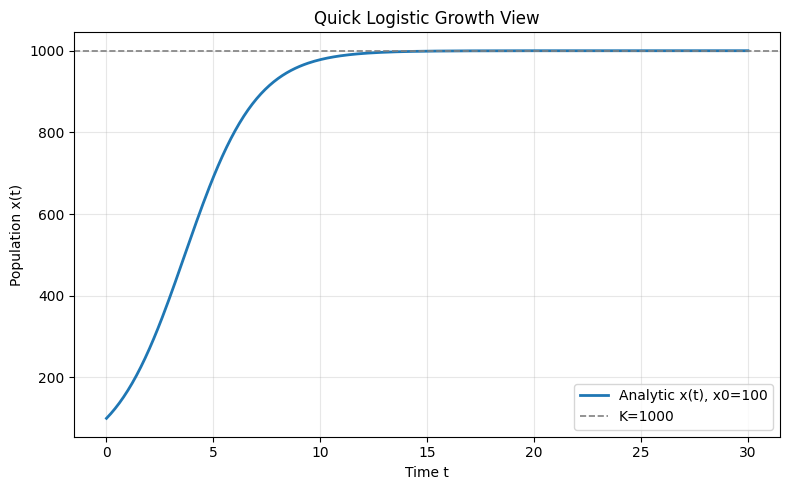

In [10]:
import numpy as np
from matplotlib import pyplot as plt

# Quick starter parameters
r_quick: float = 0.6
K_quick: float = 1000.0
x0_quick: float = 100.0

t_quick = np.linspace(0.0, 30.0, 300)
x_quick = K_quick / (1.0 + ((K_quick - x0_quick) / x0_quick) * np.exp(-r_quick * t_quick))

plt.figure(figsize=(8, 5))
plt.plot(t_quick, x_quick, linewidth=2.0, label=f"Analytic x(t), x0={x0_quick:g}")
plt.axhline(K_quick, color="gray", linestyle="--", linewidth=1.2, label=f"K={K_quick:g}")
plt.title("Quick Logistic Growth View")
plt.xlabel("Time t")
plt.ylabel("Population x(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Main Execution

Run the code cell below to:
- validate RK45 against the analytic solution across multiple parameter sets,
- check positivity and report warnings if violations occur,
- save the main figures as PNG files and display them.

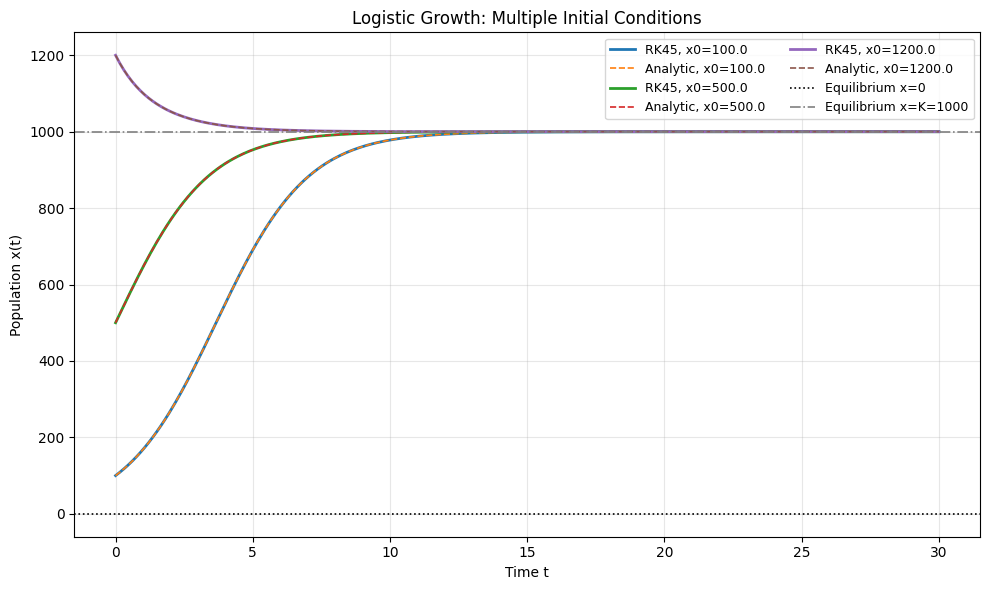

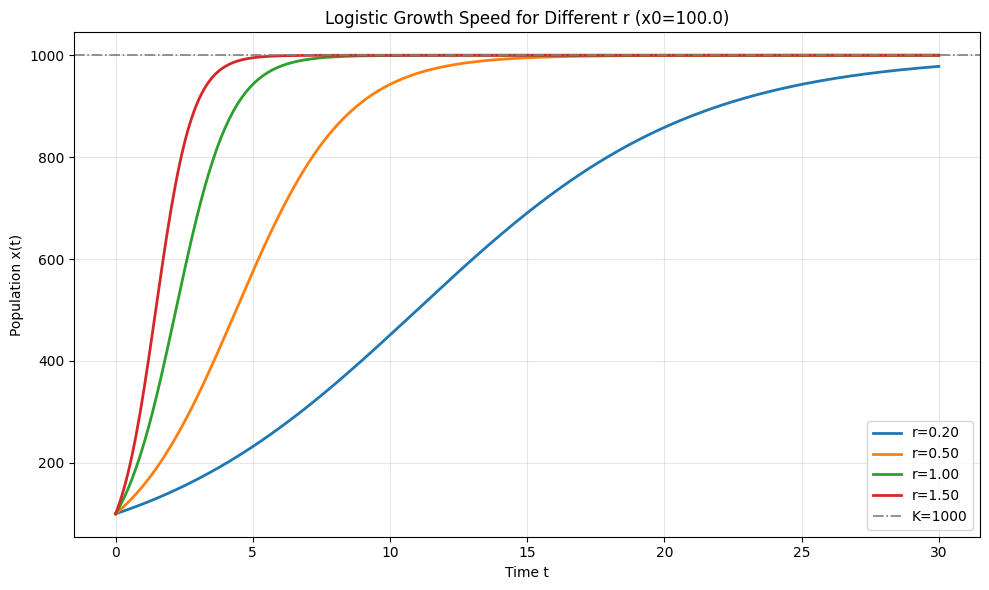

In [11]:
import numpy as np
from matplotlib import pyplot as plt

from validation import run_validation_suite
from plotting import plot_initial_condition_comparison, plot_r_sweep

# -----------------------------
# User-editable model settings
# -----------------------------
T_START: float = 0.0
T_END: float = 30.0
N_POINTS: int = 400
NEGATIVITY_TOL: float = -1e-12

R_MAIN: float = 0.6
K_MAIN: float = 1000.0
X0_LIST: list[float] = [0.1 * K_MAIN, 0.5 * K_MAIN, 1.2 * K_MAIN]

VALIDATION_CASES: list[tuple[float, float, float]] = [
    (0.3, 500.0, 50.0),
    (0.8, 1000.0, 100.0),
    (1.2, 1200.0, 1500.0),
    (0.5, 300.0, 290.0),
]

R_SWEEP: list[float] = [0.2, 0.5, 1.0, 1.5]
X0_SWEEP: float = 0.1 * K_MAIN

# -----------------------------
# Main execution
# -----------------------------
t_eval = np.linspace(T_START, T_END, N_POINTS)

_ = run_validation_suite(cases=VALIDATION_CASES, t_eval=t_eval, negativity_tol=NEGATIVITY_TOL)

_ = plot_initial_condition_comparison(
    t_eval=t_eval, r=R_MAIN, K=K_MAIN, x0_list=X0_LIST,
)

_ = plot_r_sweep(
    t_eval=t_eval, r_values=R_SWEEP, K=K_MAIN, x0=X0_SWEEP,
)

plt.show()

## 2: Logistic Growth with Fishing (Harvesting)

We now include constant proportional harvesting in the time-only logistic model:

$$
\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right) - h x
$$

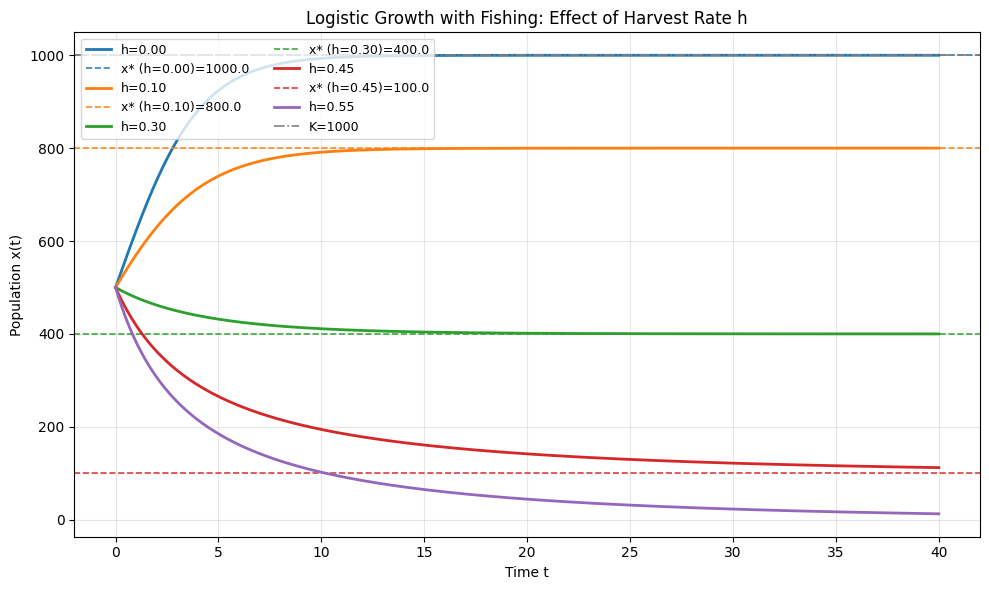

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

from ode_models import harvested_rhs

# Required parameters
K_h: float = 1000.0
r_h: float = 0.50
x0_h: float = 500.0
t_h = np.linspace(0.0, 40.0, 801)  # dense time grid
h_values: list[float] = [0.00, 0.10, 0.30, 0.45, 0.55]

fig_c, ax_c = plt.subplots(figsize=(10, 6))

for h in h_values:
    sol = solve_ivp(
        fun=lambda t, y, h_val=h: harvested_rhs(t=t, x=y, r=r_h, K=K_h, h=h_val),
        t_span=(float(t_h[0]), float(t_h[-1])),
        y0=np.array([x0_h], dtype=float),
        t_eval=t_h,
        method="RK45",
        rtol=1e-9,
        atol=1e-12,
    )
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed for h={h:.2f}: {sol.message}")

    x_num = sol.y[0]
    line, = ax_c.plot(t_h, x_num, linewidth=2.0, label=f"h={h:.2f}")

    if h < r_h:
        x_star = K_h * (1.0 - h / r_h)
        ax_c.axhline(
            x_star,
            color=line.get_color(),
            linestyle="--",
            linewidth=1.2,
            alpha=0.9,
            label=f"x* (h={h:.2f})={x_star:.1f}",
        )

ax_c.axhline(K_h, color="gray", linestyle="-.", linewidth=1.2, label=f"K={K_h:g}")
ax_c.set_title("Logistic Growth with Fishing: Effect of Harvest Rate h")
ax_c.set_xlabel("Time t")
ax_c.set_ylabel("Population x(t)")
ax_c.grid(True, alpha=0.3)
ax_c.legend(fontsize=9, ncol=2)
fig_c.tight_layout()
plt.show()

# 3A — Pure Diffusion Sanity Check (Migration Only)

**Purpose:** validate the spatial finite-difference discretisation and Neumann (no-flux) boundary conditions *before* adding logistic growth or fishing.

We solve the pure diffusion PDE on the offshore-distance domain $s \in [0, L]$:

$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial s^2}
$$

with no-flux boundaries:

$$
\frac{\partial u}{\partial s}(0,t) = 0, \qquad \frac{\partial u}{\partial s}(L,t) = 0
$$

**Expected behaviour:**
- The initial Gaussian bump (centred at $s = 150$) spreads and flattens over time.
- Total mass $M(t) = \int_0^L u(s,t)\,ds$ is conserved (no-flux + no reaction).

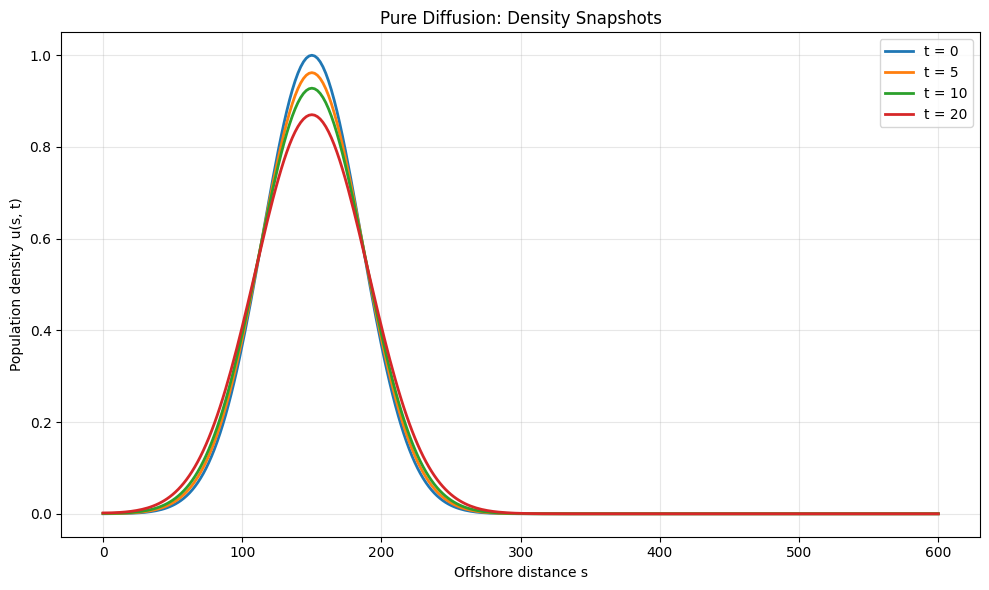

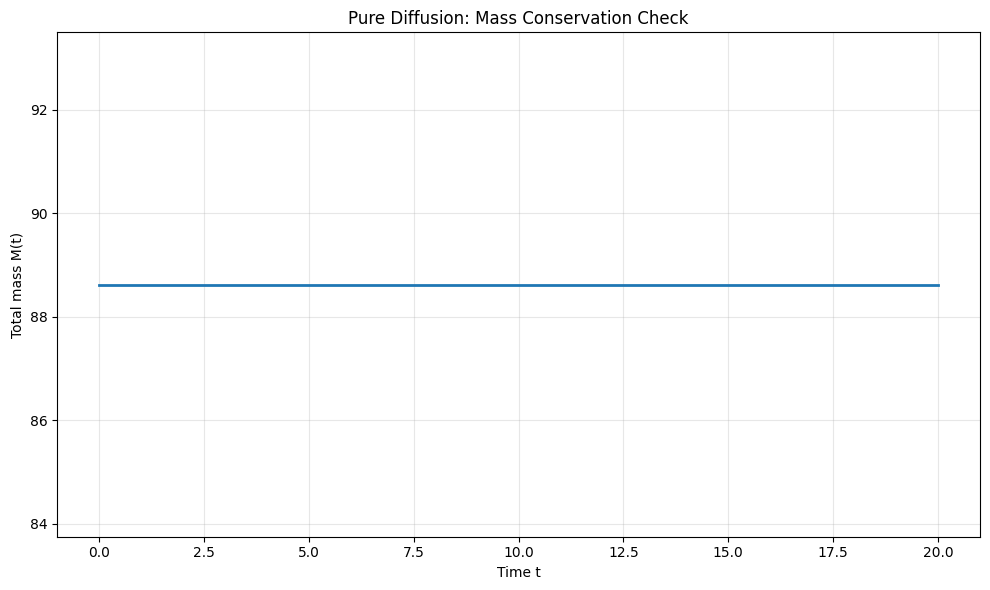

In [13]:
import numpy as np
from matplotlib import pyplot as plt

from pde_solver import laplacian_neumann

# ── Parameters ───────────────────────────────────────────────────────
L: float = 600.0          # domain length (offshore distance)
N: int = 301              # number of grid points
ds: float = L / (N - 1)   # spatial step

D: float = 10.0           # diffusion coefficient
T_end: float = 20.0       # simulation end time

# Stability-guided time step: dt <= ds^2 / (2D)
dt_max = ds**2 / (2.0 * D)
dt = 0.45 * dt_max
nt = int(np.ceil(T_end / dt))
dt = T_end / nt            # adjust so simulation lands exactly on T_end

s = np.linspace(0.0, L, N)

# ── Initial condition: Gaussian bump centred offshore ────────────────
s_peak: float = 150.0      # peak density at 150 miles offshore
u = np.exp(-((s - s_peak) / 50.0)**2)

# ── Time integration (explicit Euler) ────────────────────────────────
snapshot_times = {0.0, 5.0, 10.0, 20.0}
snapshots: dict[float, np.ndarray] = {0.0: u.copy()}

mass_history = np.empty(nt + 1)
time_history = np.empty(nt + 1)
mass_history[0] = np.trapezoid(u, s)
time_history[0] = 0.0

t = 0.0
for n in range(1, nt + 1):
    u = u + dt * D * laplacian_neumann(u, ds)
    t = n * dt
    mass_history[n] = np.trapezoid(u, s)
    time_history[n] = t
    # capture snapshots (allow small floating-point tolerance)
    for ts in list(snapshot_times):
        if abs(t - ts) < 0.5 * dt:
            snapshots[ts] = u.copy()
            snapshot_times.discard(ts)

# ── Density snapshots ───────────────────────────────────────────────
fig_a, ax_a = plt.subplots(figsize=(10, 6))
for t_snap in sorted(snapshots):
    ax_a.plot(s, snapshots[t_snap], linewidth=2.0, label=f"t = {t_snap:g}")
ax_a.set_title("Pure Diffusion: Density Snapshots")
ax_a.set_xlabel("Offshore distance s")
ax_a.set_ylabel("Population density u(s, t)")
ax_a.grid(True, alpha=0.3)
ax_a.legend()
fig_a.tight_layout()
plt.show()

# ── Mass conservation check ─────────────────────────────────────────
fig_b, ax_b = plt.subplots(figsize=(10, 6))
ax_b.plot(time_history, mass_history, linewidth=2.0)
ax_b.set_title("Pure Diffusion: Mass Conservation Check")
ax_b.set_xlabel("Time t")
ax_b.set_ylabel("Total mass M(t)")
ax_b.grid(True, alpha=0.3)
fig_b.tight_layout()
plt.show()

# 3B — Reaction–Diffusion: Logistic Growth + Migration (No Fishing)

We now combine logistic growth with spatial diffusion:

$$
\frac{\partial u}{\partial t} = r\,u\!\left(1 - \frac{u}{K}\right) + D\,\frac{\partial^2 u}{\partial s^2}
$$

on $s \in [0, L]$ with no-flux (Neumann) boundary conditions, using the same grid and `laplacian_neumann` helper from 3A.

**Two sub-experiments:**
- **(A) Non-uniform IC** — Gaussian bump centred at $s = 150$: observe growth filling the tails toward $K$ while diffusion smooths the profile.
- **(B) Uniform IC validation** — spatially constant $u_0 = 0.2K$: the PDE should reduce to the logistic ODE (no spatial gradients → no diffusion). We overlay the analytic logistic solution to confirm.

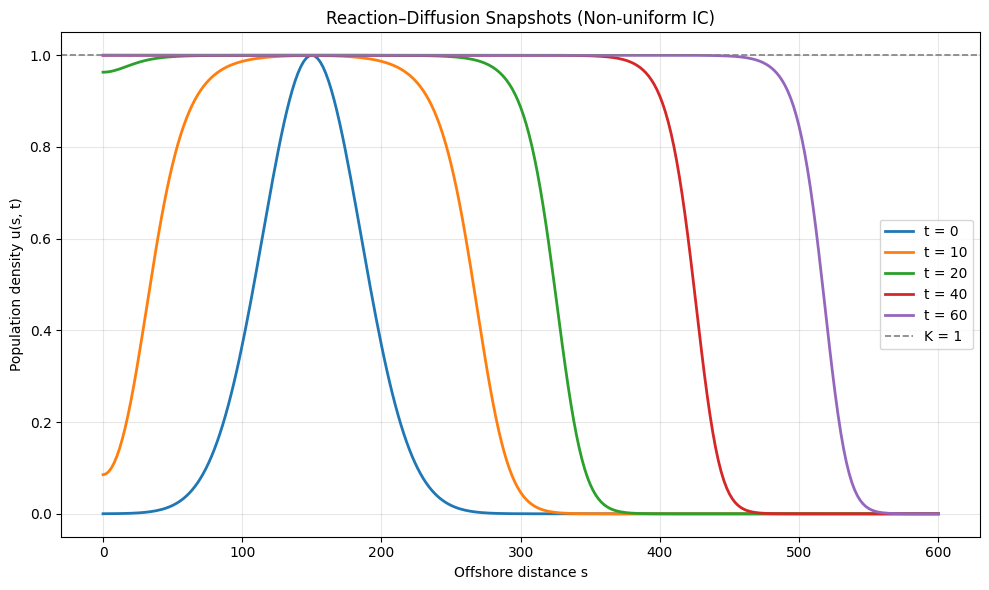

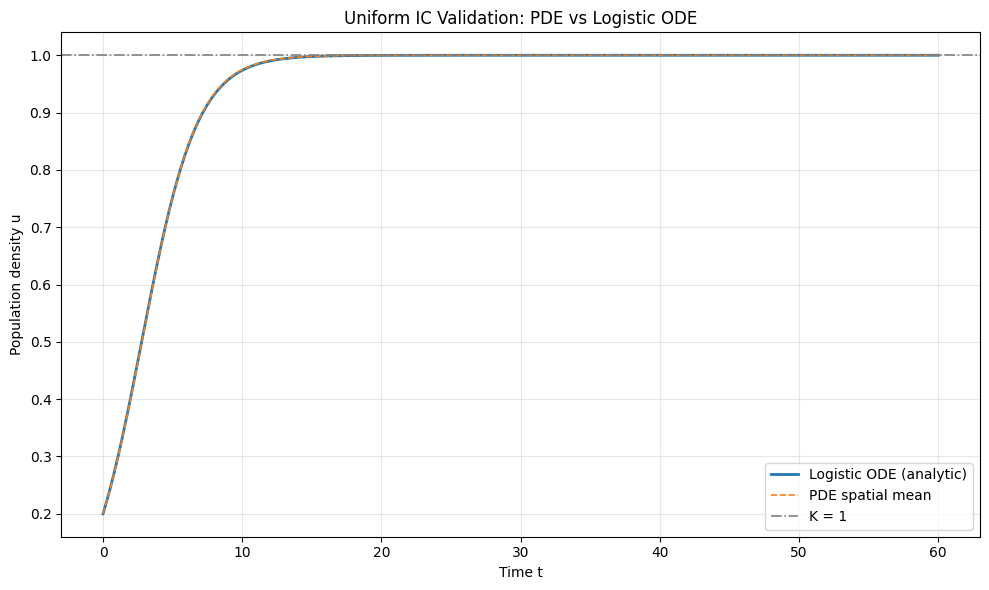

In [14]:
import numpy as np
from matplotlib import pyplot as plt

from pde_solver import laplacian_neumann
from ode_models import logistic_analytic

# ── Parameters (same grid as 3A) ────────────────────────────────────
L_rd: float = 600.0
N_rd: int = 301
ds_rd: float = L_rd / (N_rd - 1)

D_rd: float = 10.0        # diffusion coefficient (same as 3A)
K_rd: float = 1.0         # carrying capacity (O(1), consistent with Gaussian IC)
r_rd: float = 0.5         # intrinsic growth rate
T_end_rd: float = 60.0    # long enough for convergence to K

# Explicit Euler stability: dt <= ds^2 / (2D)
dt_rd = 0.45 * ds_rd**2 / (2.0 * D_rd)
nt_rd = int(np.ceil(T_end_rd / dt_rd))
dt_rd = T_end_rd / nt_rd  # adjust so we land exactly on T_end

s_rd = np.linspace(0.0, L_rd, N_rd)

# =====================================================================
# Part A — Non-uniform IC (Gaussian bump centred offshore)
# =====================================================================
s_peak_rd: float = 150.0   # peak density at 150 miles offshore
u_a = np.exp(-((s_rd - s_peak_rd) / 50.0)**2)

snapshot_times_a = {0.0, 10.0, 20.0, 40.0, 60.0}
snapshots_a: dict[float, np.ndarray] = {0.0: u_a.copy()}

t_a = 0.0
for n in range(1, nt_rd + 1):
    lap = laplacian_neumann(u_a, ds_rd)
    u_a = u_a + dt_rd * (r_rd * u_a * (1.0 - u_a / K_rd) + D_rd * lap)
    t_a = n * dt_rd
    for ts in list(snapshot_times_a):
        if abs(t_a - ts) < 0.5 * dt_rd:
            snapshots_a[ts] = u_a.copy()
            snapshot_times_a.discard(ts)

# ── Plot: Non-uniform IC snapshots ──────────────────────────────────
fig_a, ax_a = plt.subplots(figsize=(10, 6))
for t_snap in sorted(snapshots_a):
    ax_a.plot(s_rd, snapshots_a[t_snap], linewidth=2.0, label=f"t = {t_snap:g}")
ax_a.axhline(K_rd, color="gray", linestyle="--", linewidth=1.2, label=f"K = {K_rd:g}")
ax_a.set_title("Reaction–Diffusion Snapshots (Non-uniform IC)")
ax_a.set_xlabel("Offshore distance s")
ax_a.set_ylabel("Population density u(s, t)")
ax_a.grid(True, alpha=0.3)
ax_a.legend()
fig_a.tight_layout()
plt.show()

# =====================================================================
# Part B — Uniform IC validation
# =====================================================================
u0_uniform = 0.2 * K_rd
u_b = u0_uniform * np.ones(N_rd)

# Track spatial mean and max deviation at each step
mean_history = np.empty(nt_rd + 1)
max_dev_history = np.empty(nt_rd + 1)
time_history_b = np.empty(nt_rd + 1)

mean_history[0] = u_b.mean()
max_dev_history[0] = u_b.max() - u_b.min()
time_history_b[0] = 0.0

for n in range(1, nt_rd + 1):
    lap = laplacian_neumann(u_b, ds_rd)
    u_b = u_b + dt_rd * (r_rd * u_b * (1.0 - u_b / K_rd) + D_rd * lap)
    time_history_b[n] = n * dt_rd
    mean_history[n] = u_b.mean()
    max_dev_history[n] = u_b.max() - u_b.min()

# Analytic logistic ODE solution (reuse from ode_models)
u_analytic = logistic_analytic(time_history_b, r=r_rd, K=K_rd, x0=u0_uniform)

# ── Plot: Uniform IC validation ─────────────────────────────────────
fig_b, ax_b = plt.subplots(figsize=(10, 6))
ax_b.plot(time_history_b, u_analytic, linewidth=2.0, label="Logistic ODE (analytic)")
ax_b.plot(time_history_b, mean_history, "--", linewidth=1.2, label="PDE spatial mean")
ax_b.axhline(K_rd, color="gray", linestyle="-.", linewidth=1.2, label=f"K = {K_rd:g}")
ax_b.set_title("Uniform IC Validation: PDE vs Logistic ODE")
ax_b.set_xlabel("Time t")
ax_b.set_ylabel("Population density u")
ax_b.grid(True, alpha=0.3)
ax_b.legend()
fig_b.tight_layout()
plt.show()

# 3C — Reaction–Diffusion with Fishing Policy (200-mile EEZ Boundary)

We now add spatially varying harvesting to the reaction–diffusion PDE:

$$
\frac{\partial u}{\partial t} = r\,u\!\left(1 - \frac{u}{K}\right) - h(s,t)\,u + D\,\frac{\partial^2 u}{\partial s^2}
$$

The fishing rate $h(s,t)$ is **piecewise constant** across the 200-mile Exclusive Economic Zone (EEZ) boundary at $s = s_{\mathrm{boundary}}$:

$$
h(s,t) = \begin{cases} h_{\mathrm{in}} & s \le s_{\mathrm{boundary}} \quad \text{(EEZ — regulated)} \\[4pt] h_{\mathrm{out}} & s > s_{\mathrm{boundary}} \quad \text{(international waters — unregulated)} \end{cases}
$$

### Harvest rate calibration via MSY / MEY

The **Maximum Sustainable Yield** for the logistic model is:

$$
\text{MSY} = \frac{Kr}{4}, \qquad h_{\text{MSY}} = \frac{r}{2}
$$

Inside the EEZ, fishing is managed at the **Maximum Economic Yield (MEY)**, taken as a random fraction $f \in [0.80,\, 0.90]$ of MSY. The corresponding per-capita harvest rate is:

$$
h_{\text{MEY}} = \frac{r}{2}\left(1 - \sqrt{1 - f}\right)
$$

Outside the EEZ (international waters), fishing is unregulated and occurs at the MSY rate $h_{\text{MSY}} = r/2$.

**Three policy scenarios:**

| Scenario | $h_{\mathrm{in}}$ (EEZ) | $h_{\mathrm{out}}$ (international) | Description |
|----------|--------------------------|--------------------------------------|-------------|
| A | 0.0 | 0.0 | No fishing (baseline, should match 3B) |
| B | $h_{\text{MEY}}$ | $h_{\text{MEY}}$ | Uniform MEY fishing everywhere |
| C | $h_{\text{MEY}}$ | $h_{\text{MSY}}$ | EEZ managed at MEY, international waters fished at MSY |

**Expected behaviour:**
- **A:** identical to 3B — growth fills toward $K$ everywhere.
- **B:** fishing at MEY depresses the equilibrium below $K$ uniformly, but sustains near-optimal long-term yield.
- **C:** EEZ zone converges to MEY equilibrium $K(1 - h_{\text{MEY}}/r)$; international waters are fished harder at MSY, converging to the lower equilibrium $K/2$. Diffusion creates a **spillover gradient** near the boundary where fish migrate from the higher-density EEZ into the depleted international zone.

In [ ]:
import importlib
import pde_solver
importlib.reload(pde_solver)
from pde_solver import simulate_rd_fishing

In [18]:
import numpy as np
from matplotlib import pyplot as plt

from plotting import plot_snapshots, plot_biomass, plot_catch

# ── 3C: Run fishing-policy scenarios (MSY / MEY calibrated) ─────────

# Baseline parameters (same grid as 3A/3B)
L_3c: float = 600.0
N_3c: int = 301
D_3c: float = 10.0
r_3c: float = 0.5
K_3c: float = 1.0
T_end_3c: float = 60.0
S_BND: float = 200.0
n_years: int = int(T_end_3c)   # one harvest rate drawn per integer year

# ── Annual stochastic harvest schedules ──────────────────────────────
# MEY: random fraction of MSY drawn each year, f ~ U(0.80, 0.90)
MEY_frac_arr = np.random.uniform(0.80, 0.90, size=n_years)
h_MEY_arr    = r_3c * (1.0 - np.sqrt(1.0 - MEY_frac_arr)) / 2.0

# MSY: theoretical r/2 with ±10 % noise each year
h_MSY_arr = (r_3c / 2.0) * np.random.uniform(0.90, 1.10, size=n_years)

print(f"Theoretical:  h_MSY = {r_3c / 2.0:.4f},  MSY = {K_3c * r_3c / 4:.4f}")
print(f"h_MEY  — mean={h_MEY_arr.mean():.4f},  min={h_MEY_arr.min():.4f},  max={h_MEY_arr.max():.4f}")
print(f"h_MSY  — mean={h_MSY_arr.mean():.4f},  min={h_MSY_arr.min():.4f},  max={h_MSY_arr.max():.4f}")

SCENARIOS = {
    "A": {
        "label": "No Fishing (Baseline)",
        "h_in": 0.0, "h_out": 0.0, "pulse": None,
        "h_in_schedule": None, "h_out_schedule": None,
    },
    "B": {
        "label": f"Uniform MEY Fishing (mean h={h_MEY_arr.mean():.3f})",
        "h_in": h_MEY_arr.mean(), "h_out": h_MEY_arr.mean(), "pulse": None,
        "h_in_schedule": h_MEY_arr, "h_out_schedule": h_MEY_arr,
    },
    "C": {
        "label": (
            f"EEZ at MEY (mean h={h_MEY_arr.mean():.3f}), "
            f"International at MSY (mean h={h_MSY_arr.mean():.3f})"
        ),
        "h_in": h_MEY_arr.mean(), "h_out": h_MSY_arr.mean(), "pulse": None,
        "h_in_schedule": h_MEY_arr, "h_out_schedule": h_MSY_arr,
    },
}

results_3c: dict[str, dict] = {}

for key, scen in SCENARIOS.items():
    res = simulate_rd_fishing(
        L=L_3c, N=N_3c, D=D_3c, r=r_3c, K=K_3c, T_end=T_end_3c,
        s_boundary=S_BND,
        h_in=scen["h_in"], h_out=scen["h_out"], pulse=scen["pulse"],
        h_in_schedule=scen["h_in_schedule"],
        h_out_schedule=scen["h_out_schedule"],
        store_full=True,
    )
    results_3c[key] = res

# ── Generate all plots ───────────────────────────────────────────────

for key, scen in SCENARIOS.items():
    res = results_3c[key]
    tag = f"Scenario {key}: {scen['label']}"

    plot_snapshots(res, tag, K=K_3c)
    plot_biomass(res, tag)
    plot_catch(res, tag)

plt.show()


Theoretical:  h_MSY = 0.2500,  MSY = 0.1250
h_MEY  — mean=0.1540,  min=0.1391,  max=0.1707
h_MSY  — mean=0.2523,  min=0.2251,  max=0.2742


TypeError: simulate_rd_fishing() got an unexpected keyword argument 'h_in_schedule'

## 3D Surface and Heatmap Visualisations

For each scenario we plot the **full space–time density field** $u(s,t)$:

1. **3D surface plot** — offshore distance $s$ vs time $t$ vs fish density $u$. Multiple viewing angles are shown to give a complete picture.
2. **Heatmap** — the same data as a colour map, with the 200-mile policy boundary marked.

In [19]:
from matplotlib import pyplot as plt

from plotting import plot_3d_surface, plot_3d_surface_plotly, plot_heatmap

for key, scen in SCENARIOS.items():
    res = results_3c[key]
    tag = f"Scenario {key}: {scen['label']}"

    plot_3d_surface(res["s"], res["t_full"], res["u_full"], tag, res["s_boundary"])
    plot_3d_surface_plotly(res["s"], res["t_full"], res["u_full"], tag)
    plot_heatmap(res["s"], res["t_full"], res["u_full"], tag, res["s_boundary"])

plt.show()

KeyError: 'A'

In [ ]:
# ── Annual harvest schedule diagnostic ──────────────────────────────
fig_sched, ax_sched = plt.subplots(figsize=(10, 4))

years = np.arange(n_years)
ax_sched.step(years, h_MEY_arr, where="post", linewidth=1.8, label="h_MEY (EEZ, Scenarios B & C)")
ax_sched.step(years, h_MSY_arr, where="post", linewidth=1.8, linestyle="--", label="h_MSY (international, Scenario C)")
ax_sched.axhline(r_3c / 2.0, color="gray", linestyle=":", linewidth=1.2, label=f"Theoretical h_MSY = {r_3c/2:.3f}")

ax_sched.set_xlabel("Year")
ax_sched.set_ylabel("Harvest rate h")
ax_sched.set_title("Annual Stochastic Harvest Rate Schedules")
ax_sched.legend()
ax_sched.grid(True, alpha=0.3)
fig_sched.tight_layout()
plt.show()
